In [26]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression


In [1]:
from google.colab import files
uploaded = files.upload()

Saving ETH.csv to ETH.csv


In [4]:
eth_df = pd.read_csv(
    Path('ETH.csv'), 
    index_col='Date', 
    infer_datetime_format=True, 
    parse_dates=True
)

eth_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [5]:
close_df = eth_df.loc[:, ["Close"]]
close_df.head()

,Close
Date,
2017-11-09,320.884003
2017-11-10,299.252991
2017-11-11,314.681000
2017-11-12,307.907990
2017-11-13,316.716003


In [15]:
# Generate the returns using pct_change
close_df["Actual Returns"] = close_df["Close"].pct_change()
close_df = close_df.dropna()

display(close_df.head())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2018-02-18,923.921021,-0.051528,944.805511,775.863951,-1.0,-0.051528
2018-02-19,943.864990,0.021586,946.527756,782.155791,1.0,-0.021586
2018-02-20,895.370972,-0.051378,934.317993,788.030421,-1.0,-0.051378
2018-02-21,849.971008,-0.050705,903.281998,793.362971,-1.0,0.050705
2018-02-22,812.844971,-0.043679,875.512985,798.115110,-1.0,0.043679


In [16]:
short_window = 4
long_window = 100

# Create the fast and slow window columns
close_df['SMA_Fast'] = close_df['Close'].rolling(window=short_window).mean()
close_df['SMA_Slow'] = close_df['Close'].rolling(window=long_window).mean()

close_df = close_df.dropna()

display(close_df.head())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2018-05-28,516.036011,-0.098892,565.679520,639.500151,-1.0,0.098892
2018-05-29,565.388000,0.095637,560.343017,635.914821,1.0,-0.095637
2018-05-30,559.590027,-0.010255,553.420517,632.072071,-1.0,-0.010255
2018-05-31,577.645020,0.032265,554.664764,628.894812,1.0,-0.032265
2018-06-01,580.043030,0.004151,570.666519,626.195532,1.0,0.004151


In [17]:
# Create the 'Signal' column for positive or negative returns
close_df['Signal'] = 0.0
close_df.loc[(close_df['Actual Returns'] >= 0), 'Signal'] = 1
close_df.loc[(close_df['Actual Returns'] < 0), 'Signal'] = -1

display(close_df.head())
display(close_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2018-05-28,516.036011,-0.098892,565.679520,639.500151,-1.0,0.098892
2018-05-29,565.388000,0.095637,560.343017,635.914821,1.0,-0.095637
2018-05-30,559.590027,-0.010255,553.420517,632.072071,-1.0,-0.010255
2018-05-31,577.645020,0.032265,554.664764,628.894812,1.0,-0.032265
2018-06-01,580.043030,0.004151,570.666519,626.195532,1.0,0.004151


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2022-01-08,3091.972656,-0.031704,3313.494568,4052.013633,-1.0,0.031704
2022-01-09,3157.751465,0.021274,3215.335693,4050.515986,1.0,-0.021274
2022-01-10,3083.097900,-0.023641,3131.508118,4047.430022,-1.0,-0.023641
2022-01-11,3238.111572,0.050279,3142.733398,4045.627551,1.0,-0.050279
2022-01-12,3363.647217,0.038768,3210.652039,4045.463132,1.0,0.038768


In [36]:
close_df['Signal'].value_counts()
close_df['Strategy Returns'] = close_df['Actual Returns'] * close_df['Signal'].shift()

display(close_df.head())
close_df.dtypes

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2018-05-28,516.036011,-0.098892,565.679520,639.500151,-1.0,NaN
2018-05-29,565.388000,0.095637,560.343017,635.914821,1.0,-0.095637
2018-05-30,559.590027,-0.010255,553.420517,632.072071,-1.0,-0.010255
2018-05-31,577.645020,0.032265,554.664764,628.894812,1.0,-0.032265
2018-06-01,580.043030,0.004151,570.666519,626.195532,1.0,0.004151


Close               float64
Actual Returns      float64
SMA_Fast            float64
SMA_Slow            float64
Signal              float64
Strategy Returns    float64
dtype: object

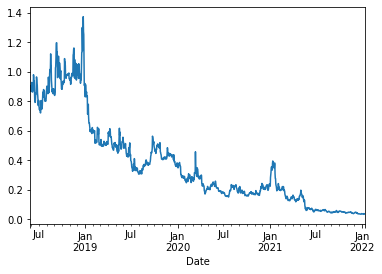

In [19]:
(1 + close_df['Strategy Returns']).cumprod().plot()

In [41]:
# Assign sma_fast and sma_slow columns X
X = close_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()
X.head()

# Create the target set 
y = close_df['Signal']
y.value_counts()

 1.0    690
-1.0    636
Name: Signal, dtype: int64

In [42]:
# Select start of training period
training_begin = X.index.min()
print(training_begin)

# Select the ending period - offset of 3 months
training_end = X.index.min() + DateOffset(months=3)
print(training_end)

2018-05-29 00:00:00
2018-08-29 00:00:00


In [43]:
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

X_train.head()

X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

X_test.head()

,SMA_Fast,SMA_Slow
Date,,
2018-08-30,286.652748,451.938972
2018-08-31,288.879753,448.302611
2018-09-01,288.230004,445.296801
2018-09-02,287.940506,442.232661
2018-09-03,289.205254,439.309031


In [44]:
# StandardScaler instance and scale the X_train
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train_scaled[:3]

array([[1.26147087, 1.90678103],
       [1.2037562 , 1.81946293],
       [1.12888883, 1.72587557]])

In [45]:
# Instantiate SVC instance
svm_model = svm.SVC()

# Fit the model 
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Make the model predictions
svm_pred = svm_model.predict(X_test_scaled)
svm_pred[:10]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [46]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

        -1.0       0.47      0.98      0.64       584
         1.0       0.10      0.00      0.00       648

    accuracy                           0.47      1232
   macro avg       0.29      0.49      0.32      1232
weighted avg       0.28      0.47      0.30      1232



In [48]:

predictions_df = pd.DataFrame(index=X_test.index)

predictions_df['Predicted'] = svm_pred

predictions_df['Actual Returns'] = close_df["Actual Returns"]
predictions_df['Strategy Returns'] = svm_pred * predictions_df['Actual Returns']

display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2018-08-30,1.0,-0.017998,-0.017998
2018-08-31,1.0,-0.003875,-0.003875
2018-09-01,1.0,0.043593,0.043593
2018-09-02,1.0,-0.003284,-0.003284
2018-09-03,1.0,-0.017366,-0.017366


,Predicted,Actual Returns,Strategy Returns
Date,,,
2022-01-08,-1.0,-0.031704,0.031704
2022-01-09,-1.0,0.021274,-0.021274
2022-01-10,-1.0,-0.023641,0.023641
2022-01-11,-1.0,0.050279,-0.050279
2022-01-12,-1.0,0.038768,-0.038768


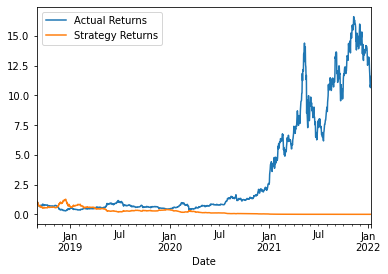

In [49]:
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()

In [50]:
logistic_regression_model = LogisticRegression()


In [51]:
model = logistic_regression_model.fit(X_train_scaled, y_train)

pred = model.predict(X_test_scaled)
pred

array([-1., -1., -1., ...,  1.,  1.,  1.])

In [52]:
lr_classification_report = classification_report(y_test, pred)
print(lr_classification_report)

              precision    recall  f1-score   support

        -1.0       0.48      0.76      0.59       584
         1.0       0.54      0.25      0.34       648

    accuracy                           0.49      1232
   macro avg       0.51      0.51      0.47      1232
weighted avg       0.51      0.49      0.46      1232



In [54]:
lr_predictions_df = pd.DataFrame(index=X_test.index)
lr_predictions_df['Predicted'] = pred

lr_predictions_df['Actual Returns'] = close_df["Actual Returns"]

lr_predictions_df['Strategy Returns'] = pred * lr_predictions_df['Actual Returns']

lr_predictions_df.head()

,Predicted,Actual Returns,Strategy Returns
Date,,,
2018-08-30,-1.0,-0.017998,0.017998
2018-08-31,-1.0,-0.003875,0.003875
2018-09-01,-1.0,0.043593,-0.043593
2018-09-02,-1.0,-0.003284,0.003284
2018-09-03,-1.0,-0.017366,0.017366


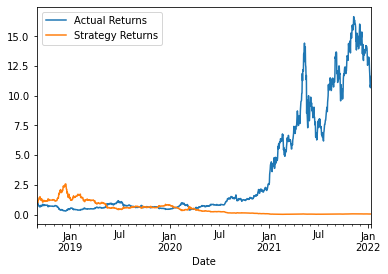

In [55]:

(1 + lr_predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()